## Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix,accuracy_score,confusion_matrix
from skopt import BayesSearchCV
from IPython.display import display

## Reading Dataset 

In [2]:
df=pd.read_csv("bbc-text.csv")
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


## Data preprocessing

#### By using Label encoder encoding Output feature

In [3]:
encoder=LabelEncoder()
df["category_labels"]=encoder.fit_transform(df["category"])
df

,category,text,category_labels
0,tech,tv future in the hands of viewers with home th...,4
1,business,worldcom boss left books alone former worldc...,0
2,sport,tigers wary of farrell gamble leicester say ...,3
3,sport,yeading face newcastle in fa cup premiership s...,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,1
...,...,...,...
2220,business,cars pull down us retail figures us retail sal...,0
2221,politics,kilroy unveils immigration policy ex-chatshow ...,2
2222,entertainment,rem announce new glasgow concert us band rem h...,1
2223,politics,how political squabbles snowball it s become c...,2


In [4]:
encoder.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

#### Removing stopwords, unwanted spaces and characters from data

In [5]:
def create_corpus(sent):
    sent = re.sub("[^a-zA-z]"," ",sent)
    sent = sent.lower()
    sent = sent.split()
    sent = [le.lemmatize(word) for word in sent if not word in stopwords.words("english")]
    sent = " ".join(sent)
    return(sent)

In [6]:
%%time
le=WordNetLemmatizer()
corpus = []
for i in range(len(df)):
    s=create_corpus(df["text"][i])
    corpus.append(s)

Wall time: 3min 41s


#### Converting text data into numerical data using TF-IDF vectorizer

In [7]:
%%time
tfidf = TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X = tfidf.fit_transform(corpus).toarray()
y = df["category_labels"]

Wall time: 3.79 s


In [8]:
print(X.shape)
print(y.shape)

(2225, 5000)
(2225,)


#### Handling inbalanced classes by doing upsampling using SMOTE(Synthetic Minority Over-sampling TEchnique)

In [9]:
df["category"].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [10]:
sm = SMOTE(random_state=753)
X_sampled, y_sampled = sm.fit_resample(X, y)

In [11]:
y_sampled.value_counts()

3    511
1    511
4    511
2    511
0    511
Name: category_labels, dtype: int64

In [12]:
print(X_sampled.shape)
print(y_sampled.shape)

(2555, 5000)
(2555,)


## Spliting Dataset into train and test data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.20, random_state=951)

## Model creation

In [14]:
def create_model(model):
    model.fit(X_train,y_train)
    print("Training Accuracy: ",model.score(X_train,y_train)*100)
    pred = model.predict(X_test)
    print(f"Testing Accuracy: {accuracy_score(y_test,pred)*100}")
    print("Confusion matrix of Testing dataset")
    plot_confusion_matrix(model,X_test,y_test,cmap="Blues",xticks_rotation=60)

#### K-Nearest Neighbors

Training Accuracy:  93.24853228962819
Testing Accuracy: 86.88845401174167
Confusion matrix of Testing dataset


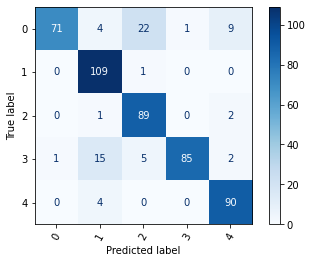

In [15]:
knn=KNeighborsClassifier()
create_model(knn)

#### Multinomial Naive Bayes

Training Accuracy:  98.5812133072407
Testing Accuracy: 98.23874755381604
Confusion matrix of Testing dataset


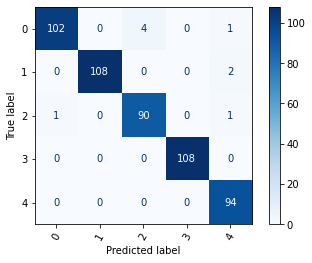

In [16]:
mnb=MultinomialNB()
create_model(mnb)

#### Decision tree

Training Accuracy:  100.0
Testing Accuracy: 85.90998043052838
Confusion matrix of Testing dataset


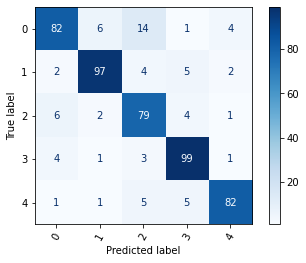

In [17]:
dt=DecisionTreeClassifier()
create_model(dt)

#### Random forest

Training Accuracy:  100.0
Testing Accuracy: 98.04305283757338
Confusion matrix of Testing dataset


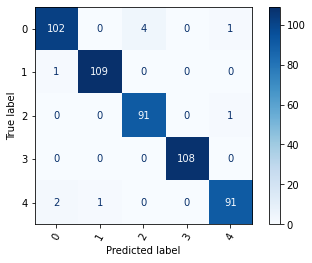

In [18]:
rf=RandomForestClassifier()
create_model(rf)

#### SVC (Support Vector Classification)

Training Accuracy:  100.0
Testing Accuracy: 98.23874755381604
Confusion matrix of Testing dataset


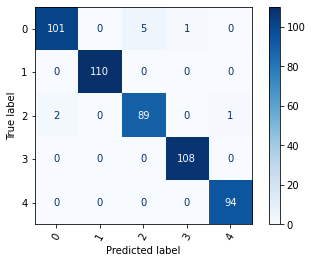

In [19]:
svc=SVC()
create_model(svc)

#### Hyperparameter optimization using Bayesian algoritham with cross-validation on Multinomial Naive Bayes

In [20]:
%%time
opt_mnb = BayesSearchCV(
    MultinomialNB(),
    {
        'alpha': (0.01, 1.0),
    },
    n_iter=16,
    cv=3
)

opt_mnb.fit(X_train, y_train)

print("Best validation score: %s" % opt_mnb.best_score_)
print("testdata score: %s" % opt_mnb.score(X_test, y_test))

Best validation score: 0.9784735812133072
testdata score: 0.9823874755381604
Wall time: 7.5 s


#### Doing prediction on a example 

In [30]:
def make_prediction():
    y_pred = [input()]
    y_pred = tfidf.transform(y_pred)
    print(f"output: {encoder.classes_[opt_mnb.best_estimator_.predict(y_pred)[0]]}\n\n")
    result=pd.DataFrame(opt_mnb.best_estimator_.predict_proba(y_pred)[0].round(2), encoder.classes_, 
                        columns=["Probability"]).sort_values(by="Probability",ascending=False)
    display(result)

In [31]:
make_prediction()

Elon Musk’s SpaceX hints at India ambitions for Starlink’s satellite internet
output: tech




,Probability
tech,0.47
business,0.26
entertainment,0.11
politics,0.09
sport,0.06


Saving final model and vectorizer in .pkl file for further use and we dont have to train model again

In [32]:
pickle.dump(opt_mnb, open("model.pkl", "wb"))
pickle.dump(tfidf, open("vectorizer.pkl", "wb"))